<a href="https://colab.research.google.com/github/izmailovpavel/neurips_bdl_starter_kit/blob/main/evaluation_phase_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Approximate Inference in Bayesian Deep Learning *Evaluation Phase*: Getting Started in pytorch

In this colab we will walk you through downloading the data, running your method and generating a submission for the evaluation phase of our NeurIPS 2021 competition. In this colab we use the pytorch framework.

See also our [getting started guide](https://colab.sandbox.google.com/github/izmailovpavel/neurips_bdl_starter_kit/blob/main/getting_started_pytorch.ipynb) for the development phase, for developing and testing your methods against our HMC samples.

Useful references:
- [Competition website](https://izmailovpavel.github.io/neurips_bdl_competition/)
- [Efficient implementation of several baselines in JAX](https://github.com/google-research/google-research/tree/master/bnn_hmc)
- [Submission platform](https://competitions.codalab.org/competitions/35838)


## Setting up colab

Colab provides an easy-to-use environment for working on the competition with access to free computational resources. However, you should also be able to run this notebook locally after installing the required dependencies. If you use colab, please select a `GPU` runtime type.

## Preparing the data

In [ ]:
# uncomment order to re-install the starter kit
# !rm -rf neurips_bdl_starter_kit

!git clone https://github.com/izmailovpavel/neurips_bdl_starter_kit
!pip install einops

import sys
import math
import matplotlib
import numpy as onp
import einops
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from matplotlib import pyplot as plt
import tqdm

sys.path.append("neurips_bdl_starter_kit")
import pytorch_models as models

fatal: destination path 'neurips_bdl_starter_kit' already exists and is not an empty directory.


We provide the datasets used in this competition in a public Google Cloud Storage bucket in the `.npz` format. You can also download the data to your computer using these links:

- [CIFAR-10](https://storage.googleapis.com/neurips2021_bdl_competition/evaluation_phase/cifar_anon.npz)
- [MedMNIST](https://storage.googleapis.com/neurips2021_bdl_competition/evaluation_phase/dermamnist_anon.npz)
- [UCI-Gap](https://storage.googleapis.com/neurips2021_bdl_competition/evaluation_phase/energy_anon.npz)
- [Diabetic Retinopathy](https://storage.googleapis.com/neurips2021_bdl_competition/evaluation_phase/retinopathy_anon.npz)

In colab, you can download the data using `gsutil`. In this colab we will use the [*Diabetic Retinopathy*](https://github.com/google/uncertainty-baselines/tree/main/baselines/diabetic_retinopathy_detection) dataset as our main example.

**Note:** for each of the datasets, we provide the data after applying the same preprocessing that was used in our HMC runs.

**Note:** we do not include the true test set labels `y_test` for the evaluation datasets. You are not allowed to use the true labels on the test data in your submissions.

In [ ]:
# !gsutil -m cp -r gs://neurips2021_bdl_competition/evaluation_phase/retinopathy_anon.npz .
data = onp.load("retinopathy_anon.npz")
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]

x_train_ = einops.rearrange(x_train, "n h w c -> n c h w")
x_test_ = einops.rearrange(x_test, "n h w c -> n c h w")

In this dataset, the goal is to detect diabetic retinopathy using images of blood vessels in the eye.

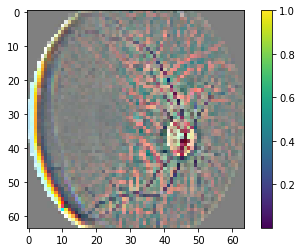

In [ ]:
plt.imshow(x_train[1])
plt.colorbar()

We define a tf.data.Dataset for the train and test datasets.

In [ ]:
train_dataset = TensorDataset(torch.from_numpy(x_train_).float(),
                              torch.from_numpy(y_train).long())
test_dataset = TensorDataset(torch.from_numpy(x_test_).float(),
                             torch.from_numpy(y_test).long())

## Model and Losses

We provide the code for all the models used in the competition in the `neurips_bdl_starter_kit/pytorch_models.py` module. Here, we will load a CNN model that we used on the diabetic retinopathy detection problem.

We also define the cross-entropy likelihood (`log_likelihood_fn`) and Gaussian prior (`log_prior_fn`), and the corresponding posterior log-density (`log_posterior_fn`).

The `evaluate_fn` function computes the accuracy and predictions of the model on a given dataset; we will use this function to generate the predictions for our submission.

**Warning:** The diabetic retinopathy dataset shows significant class imbalance. When training with SGD, it struggles to fit the data, as we will see below.

In [ ]:
!nvidia-smi

Tue Oct 12 16:48:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model = models.get_model("retinopathy_cnn", data_info={"num_classes": 2})
model.cuda()
prior_variance = 0.05

def log_likelihood_fn(model, batch):
    """Computes the log-likelihood."""
    x, y = batch
    if torch.cuda.is_available():
      x = x.cuda()
      y = y.cuda()
    model.zero_grad()
    logits = model(x)
    num_classes = logits.shape[-1]
    labels = F.one_hot(y, num_classes=num_classes)
    softmax_xent = torch.sum(labels * F.log_softmax(logits))

    return softmax_xent


def log_prior_fn(model):
    """Computes the Gaussian prior log-density."""
    n_params = sum(p.numel() for p in model.parameters())
    exp_term = sum((-p**2 / (2 * prior_variance)).sum()
                   for p in model.parameters())
    norm_constant = -0.5 * n_params * math.log((2 * math.pi * prior_variance))
    return exp_term + norm_constant


def log_posterior_fn(model, batch):
    log_lik = log_likelihood_fn(model, batch)
    log_prior = log_prior_fn(model)
    return log_lik + log_prior


def get_accuracy_fn(model, batch):
    x, y = batch
    if torch.cuda.is_available():
      x = x.cuda()
      y = y.cuda()

    logits = model(x)
    probs = F.softmax(logits, dim=1)
    preds = torch.argmax(logits, dim=1)
    accuracy = (preds == y).float().mean()
    return accuracy, probs


def evaluate_fn(model, data_loader):
    model.eval()
    sum_accuracy = 0
    all_probs = []
    with torch.no_grad():
        for bacth in data_loader:       
            batch_accuracy, batch_probs = get_accuracy_fn(model, bacth)
            sum_accuracy += batch_accuracy.item()
            all_probs.append(batch_probs.detach())
    all_probs = torch.cat(all_probs, dim=0)
    model.train()
    return sum_accuracy / len(data_loader), all_probs

## Optimizer

In this colab we will train an approximate maximum-a-posteriori (MAP) solution as our submission for simplicity. You can find efficient implementations of more advanced baselines (in JAX) [here](https://github.com/google-research/google-research/tree/master/bnn_hmc).

We will use SGD with momentum. You can adjust the hyper-parameters or switch to a different optimizer by changing the code below.

In [ ]:
batch_size = 100
test_batch_size = 100
num_epochs = 1
momentum_decay = 0.9
init_lr = 0.001

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=len(train_loader)*num_epochs)

## Training

We will run training for 1 epoch, which can take several minutes to complete. Note that in order to achieve good results you need to run the method substantially longer and tune the hyper-parameters.

In [ ]:
for epoch in range(num_epochs):
    sum_loss = 0.
    for i, batch in tqdm.tqdm(enumerate(train_loader)):
      optimizer.zero_grad()
      loss = - log_posterior_fn(model, batch)
      loss.backward()
      optimizer.step()
      scheduler.step()
      sum_loss += loss
      if i % 50 == 0:
        print(f"\tPosterior Log-density: {-loss}")

    
    print("Epoch {}".format(epoch))
    print("\tAverage loss: {}".format(sum_loss / len(train_loader)))

_, all_test_probs = evaluate_fn(model, test_loader)
train_acc, _ = evaluate_fn(model, train_loader)
print(f"Train accuracy: {train_acc}")
all_test_probs = all_test_probs.cpu().numpy()

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
3it [00:00, 12.02it/s]

	Posterior Log-density: 38748.19140625


53it [00:04, 11.90it/s]

	Posterior Log-density: 39729.33203125


103it [00:08, 11.94it/s]

	Posterior Log-density: 39741.8984375


153it [00:13, 11.93it/s]

	Posterior Log-density: 39739.01953125


203it [00:17, 11.97it/s]

	Posterior Log-density: 39729.92578125


253it [00:21, 11.85it/s]

	Posterior Log-density: 39734.359375


303it [00:26, 11.90it/s]

	Posterior Log-density: 39743.5703125


352it [00:30, 11.59it/s]

	Posterior Log-density: 39738.1484375
Epoch 0
	Average loss: -39718.4921875


Train accuracy: 0.8071568843654611


Due to class imbalance, with default parameters the model learns to always predict class `0`. Be sure to check that your methods produce more meaningful predictions:

In [ ]:
(onp.argmax(all_test_probs, axis=1) == 0).mean()

1.0

## Preparing the submission
Once you run the code above, `all_test_probs` should contain an array of size 42670 x 2 where the rows correspond to test datapoints and columns correspond to classes.

Now, we need to save the array as `retinopathy_probs.csv` and create a zip archive with this file.

In [ ]:
onp.savetxt("retinopathy_probs.csv", all_test_probs)

!zip submission.zip retinopathy_probs.csv

  adding: retinopathy_probs.csv (deflated 100%)


Finally, you can download the submission by running the code below. If the download doesn't start, check that your browser did not block it automatically.

In [ ]:
from google.colab import files
files.download('submission.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now you can head over to the [submission system](https://competitions.codalab.org/competitions/35838) and upload your submission. Good luck :)

## Extended track

If you want to participate in the extended track, you will need to produce predictions on 3 additional datasets: CIFAR-10 (with AlexNet-like architecture), [UCI-Gap](https://arxiv.org/abs/1906.11537) (Energy) and [MedMNIST](https://medmnist.com/) (dermamnist). 

Here, we will walk you through the datasets, architectures and priors and show you how to prepare the full submission.

### Classification datasets

For CIFAR-10 and MedMNIST the process of loading the data and model and preparing the predictions is fully analogous to Diabetic Retinopathy (see above for a detailed walk-through). So, we will simply show how to download the data and get the corresponding models.

**Note**: note that the prior variance differs between datasets. We list the correct value for each dataset.

#### CIFAR-10

In [ ]:
!gsutil -m cp -r gs://neurips2021_bdl_competition/evaluation_phase/cifar_anon.npz .
data = onp.load("cifar_anon.npz")
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]

x_train_ = einops.rearrange(x_train, "n h w c -> n c h w")
x_test_ = einops.rearrange(x_test, "n h w c -> n c h w")

Copying gs://neurips2021_bdl_competition/evaluation_phase/cifar_anon.npz...
\ [1/1 files][  1.1 GiB/  1.1 GiB] 100% Done  42.6 MiB/s ETA 00:00:00           
Operation completed over 1 objects/1.1 GiB.                                      


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


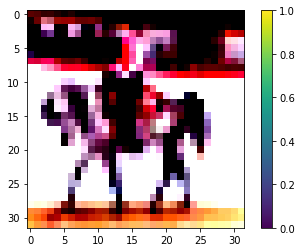

In [ ]:
plt.imshow(x_train[0])
plt.colorbar()

In [ ]:
model = models.get_model("cifar_alexnet", data_info={"num_classes": 10})
prior_variance = 0.05

In [ ]:
n_test = len(y_test)
cifar_fake_preds = F.softmax(torch.randn(n_test, 10)).numpy()
onp.savetxt("cifar_probs.csv", cifar_fake_preds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


#### MedMNIST

In [ ]:
!gsutil -m cp -r gs://neurips2021_bdl_competition/evaluation_phase/dermamnist_anon.npz .
data = onp.load("dermamnist_anon.npz")
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]

x_train_ = einops.rearrange(x_train, "n h w c -> n c h w")
x_test_ = einops.rearrange(x_test, "n h w c -> n c h w")

Copying gs://neurips2021_bdl_competition/evaluation_phase/dermamnist_anon.npz...
\ [1/1 files][ 20.2 MiB/ 20.2 MiB] 100% Done                                    
Operation completed over 1 objects/20.2 MiB.                                     


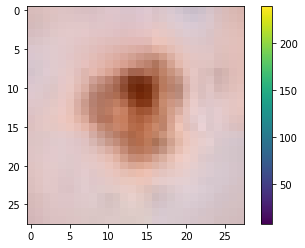

In [ ]:
plt.imshow(x_train[4])
plt.colorbar()

In [ ]:
model = models.get_model("medmnist_lenet", data_info={"num_classes": 7})
prior_variance = 0.01

In [ ]:
n_test = len(y_test)
medmnist_fake_preds = F.softmax(torch.randn(n_test, 10)).numpy()
onp.savetxt("medmnist_probs.csv", medmnist_fake_preds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


### UCI Regression

For the regression data, we use a slightly different output format. We will walk you through defining the model and generating predictions here.

In [ ]:
!gsutil -m cp -r gs://neurips2021_bdl_competition/evaluation_phase/energy_anon.npz .
data = onp.load("energy_anon.npz")
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]

Copying gs://neurips2021_bdl_competition/evaluation_phase/energy_anon.npz...
/ [1/1 files][ 54.0 KiB/ 54.0 KiB] 100% Done                                    
Operation completed over 1 objects/54.0 KiB.                                     


In [ ]:
model = models.get_model("uci_mlp", {"num_features": x_train.shape[1]})
prior_variance = 1 / 30

Our model will output a Gaussian distribution for each of the input points. Specifically, the model produces two scalar outputs: $\mu$ and $\sigma_{isp}$, the mean and the inverse [softplus](https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html) of the standard deviation. Let us define the likelihood for this model.

In [ ]:
train_dataset = (torch.from_numpy(x_train).float(),
                 torch.from_numpy(y_train).float())
test_dataset = (torch.from_numpy(x_test).float(),
                torch.from_numpy(y_test).float())

def log_likelihood_fn(model, batch):
    """Computes the negative log-likelihood.

    The outputs of the network should be two-dimensional.
    The first output is treated as predictive mean. The second output is treated
    as inverse-softplus of the predictive standard deviation.
    """
    x, y = batch
    predictions = model(x)

    predictions_mean, predictions_std = predictions.split([1, 1], dim=-1)
    predictions_std = F.softplus(predictions_std)

    se = (predictions_mean - y)**2
    log_likelihood = (-0.5 * se / predictions_std**2 -
                      0.5 * torch.log(predictions_std**2 * 2 * math.pi))
    log_likelihood = torch.sum(log_likelihood)

    return log_likelihood

def log_prior_fn(model):
    """Computes the Gaussian prior log-density."""
    n_params = sum(p.numel() for p in model.parameters())
    exp_term = sum((-p**2 / (2 * prior_variance)).sum()
                   for p in model.parameters())
    norm_constant = -0.5 * n_params * math.log((2 * math.pi * prior_variance))
    return exp_term + norm_constant


def log_posterior_fn(model, batch):
    log_lik = log_likelihood_fn(model, batch)
    log_prior = log_prior_fn(model)
    return log_lik + log_prior

Now let's train the model similarly to the Diabetic Retinopathy example.

In [ ]:
num_epochs = 1000#0000
momentum_decay = 0.9
init_lr = 1.e-6 

optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_epochs)

In [ ]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = - log_posterior_fn(model, train_dataset)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 50 == 0:
      print(f"\tPosterior Log-density: {-loss}")

	Posterior Log-density: -396.9594421386719
	Posterior Log-density: -135.68423461914062
	Posterior Log-density: 10.719512939453125
	Posterior Log-density: 127.45893859863281
	Posterior Log-density: 216.31890869140625
	Posterior Log-density: 270.1925048828125
	Posterior Log-density: 297.53289794921875
	Posterior Log-density: 318.3979187011719
	Posterior Log-density: 336.37774658203125
	Posterior Log-density: 351.7747802734375
	Posterior Log-density: 365.06304931640625
	Posterior Log-density: 376.2654724121094
	Posterior Log-density: 385.3034362792969
	Posterior Log-density: 392.2835693359375
	Posterior Log-density: 397.57708740234375
	Posterior Log-density: 401.3660888671875
	Posterior Log-density: 403.9302062988281
	Posterior Log-density: 405.510009765625
	Posterior Log-density: 406.33074951171875
	Posterior Log-density: 406.63677978515625


We can now compute and visualize the predictions on the train set. As we can see, the model was able to fit the train data.

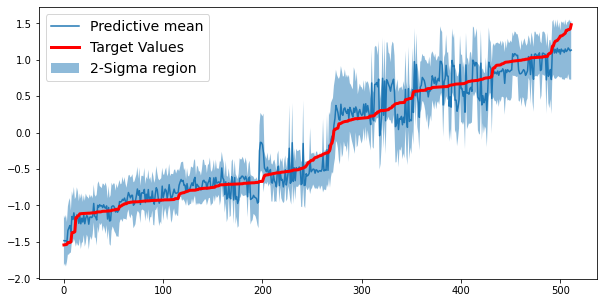

In [ ]:
plt.figure(figsize=(10, 5))
idx = onp.argsort(y_train[:, 0])

train_preds = model(train_dataset[0]).detach().cpu()
mu, sigma = train_preds.split([1, 1], dim=-1)
sigma = F.softplus(sigma)
mu, sigma = mu[:, 0][idx], sigma[:, 0][idx]

# mu = train_preds[:, 0][idx].numpy()
# sigma = train_preds[:, 1][idx]
# sigma = F.softplus(sigma).numpy()

plt.plot(mu, label="Predictive mean")
plt.fill_between(onp.arange(len(mu)), mu + 2 * sigma, mu - 2 * sigma, alpha=0.5,
                 label="2-Sigma region")
plt.plot(y_train[:, 0][idx], "-r", lw=3, label="Target Values")
plt.legend(fontsize=14)

Now, let us produce the predictions on the test data that we will use in our submission. For UCI-Gap, we ask you to submit a CSV file with 256 rows and 1000 columns. Each row corresponds to a test datapoint $x_i$, and each colum corresponds to a sample from the predictive distribution $p(y \vert x_i)$. In our case, the predictive distribution is Gaussian, so we can produce the samples as follows:

In [ ]:
num_samples = 1000
num_data = len(y_test)

test_preds = model(test_dataset[0]).detach().cpu()
mu, sigma = test_preds.split([1, 1], dim=-1)
sigma = F.softplus(sigma)
mu, sigma = mu[:, 0].numpy(), sigma[:, 0].numpy()

eps = onp.random.randn(num_data, num_samples)
samples = mu[:, None] + eps * sigma[:, None]
samples.shape

(256, 1000)

Let us save the samples to a CSV file.

In [ ]:
onp.savetxt("uci_samples.csv", samples)

Now we can finally prepare the submission file!

In [ ]:
!zip extended_submission.zip retinopathy_probs.csv cifar_probs.csv medmnist_probs.csv uci_samples.csv 

from google.colab import files
files.download('extended_submission.zip') 

  adding: retinopathy_probs.csv (deflated 100%)
  adding: cifar_probs.csv (deflated 57%)
  adding: medmnist_probs.csv (deflated 57%)
  adding: uci_samples.csv (deflated 60%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>